In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

import numpy as np
np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=4)

import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 50)
#pd.set_option('precision', 5)

In [3]:
os.chdir('/Users/zacklarsen/Dropbox/Inference Analytics Team Folder/Zack Work')
!ls *csv

AirbnbChicago.csv     AirbnbSanDiego.csv    kc_house_data.csv
AirbnbLA.csv          CountDF.csv           neighborhoods.csv
AirbnbNYC.csv         LA_Crime.csv          sample_submission.csv
AirbnbOakland.csv     Online Retail.csv     train_2016_v2.csv
AirbnbSF.csv          Tuesday.csv


# Use online retail dataset
## http://archive.ics.uci.edu/ml/datasets/online+retail#

In [ ]:
%%time
import time

time.OR = pd.read_csv('Online Retail.csv',parse_dates=['InvoiceDate'])
OR['D_O_W'] = OR['InvoiceDate'].apply(lambda x: x.weekday())
OR['Date'] = OR['InvoiceDate'].apply(lambda x: x.date())

In [6]:
%%time

time.OR.sort_values(['InvoiceNo','StockCode'],ascending=['False','False'],inplace=True)

## Remove invoice numbers beginning with 'C' for returns and 'A' for bad debt adjustments

OR = OR[~OR['InvoiceNo'].str.startswith("C")]
OR = OR[~OR['InvoiceNo'].str.startswith("A")]

## Calculate invoice total
OR['Total Amount'] = OR['Quantity']*OR['UnitPrice']

In [63]:
# sessions = pd.DataFrame(OR.groupby('InvoiceNo')['StockCode'].apply(list))
# sessions = pd.DataFrame(OR.groupby('InvoiceNo')['Description'].apply(list))

# len(sessions)

# sessions.head(5)

# ORweekdays = pd.DataFrame(OR.groupby(['D_O_W','Country'])['Description'].agg(lambda x:x.value_counts().index[0]))

# ORweekdays = ORweekdays.unstack(0)

# #ORweekdays

In [7]:
Invoices = pd.DataFrame(OR.groupby(['InvoiceNo','CustomerID','Date'])['Total Amount'].sum().reset_index())

In [8]:
Invoices.head(5)

,InvoiceNo,CustomerID,Date,Total Amount
0,536365,17850.0,2010-12-01,139.12
1,536366,17850.0,2010-12-01,22.20
2,536367,13047.0,2010-12-01,278.73
3,536368,13047.0,2010-12-01,70.05
4,536369,13047.0,2010-12-01,17.85


In [9]:
Invoices['Date'].min()
Invoices['Date'].max()

datetime.date(2010, 12, 1)

datetime.date(2011, 12, 9)

# Use lifetimes package
### http://lifetimes.readthedocs.io/en/master/Quickstart.html

In [10]:
import lifetimes
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix,plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data,calibration_and_holdout_data

In [11]:
## Create RFM matrix

summary = summary_data_from_transaction_data(Invoices, 'CustomerID', 'Date',monetary_value_col='Total Amount', observation_period_end='2011-12-09')

print(summary.head())

            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           0.0      0.0  325.0        0.000000
12347.0           6.0    365.0  367.0      599.701667
12348.0           3.0    283.0  358.0      301.480000
12349.0           0.0      0.0   18.0        0.000000
12350.0           0.0      0.0  310.0        0.000000


In [15]:
summary[summary['monetary_value'] < 0]  # Check for negativity

,frequency,recency,T,monetary_value
CustomerID,,,,


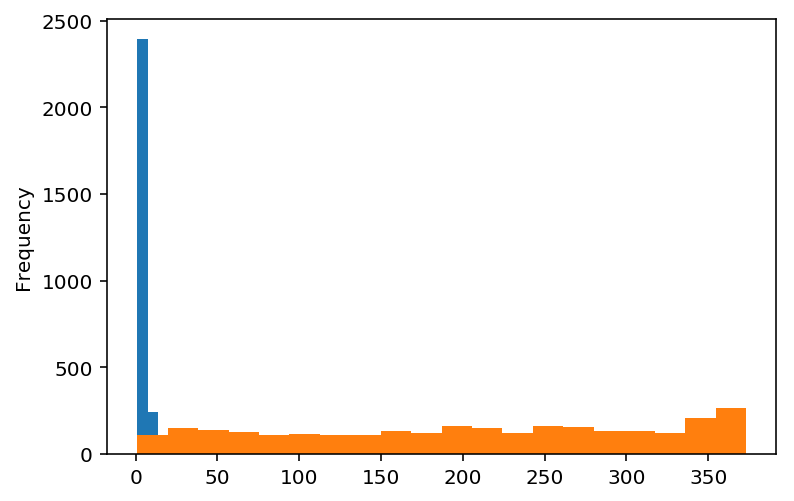

In [16]:
summary[summary['frequency'] > 0]['frequency'].plot(kind='hist', bins=20) #subplot 1
summary[summary['recency'] > 0]['recency'].plot(kind='hist', bins=20) #subplot 2

In [17]:
print (summary[summary['frequency'] > 0]['frequency'].describe()) #Descriptive statistics
print (summary[summary['recency'] > 0]['recency'].describe()) #Descriptive statistics

count    2790.000000
mean        4.454122
std         6.930419
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       131.000000
Name: frequency, dtype: float64
count    2790.000000
mean      203.328674
std       111.459556
min         1.000000
25%       106.000000
50%       211.000000
75%       301.750000
max       373.000000
Name: recency, dtype: float64


In [134]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)

NameError: name 'summary' is not defined

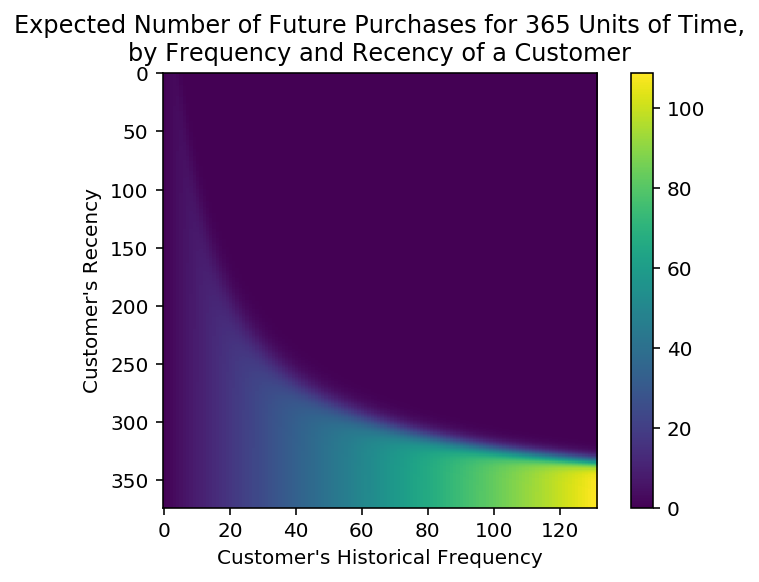

In [19]:
from lifetimes.plotting import plot_frequency_recency_matrix,plot_probability_alive_matrix

plot_frequency_recency_matrix(bgf,365)

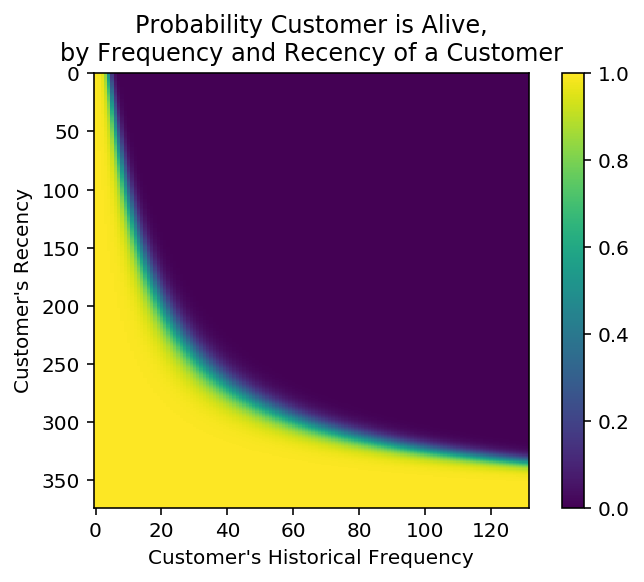

In [20]:
plot_probability_alive_matrix(bgf)

## Assess model fit

//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/generate_data.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  lambda_ = stats.gamma.rvs(r, scale=1. / alpha, size=size)


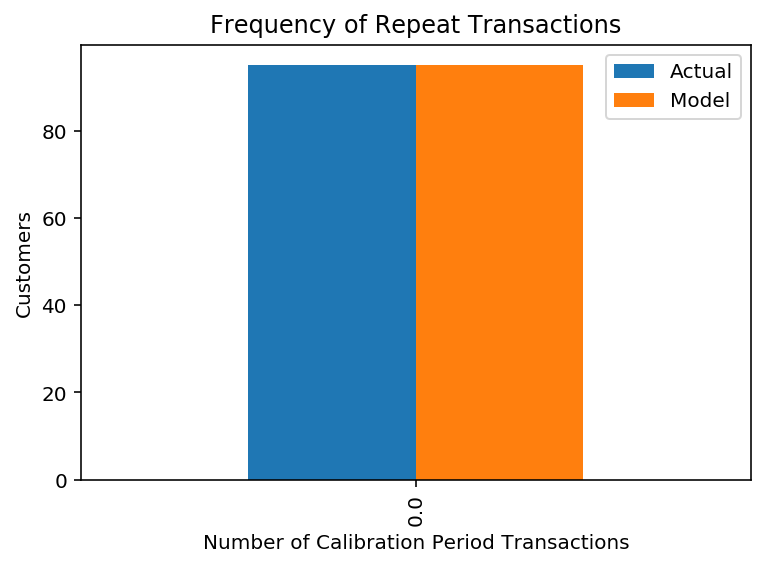

In [132]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

In [39]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 69.00, b: 1.22, r: 0.83>

CustomerID
12346.0     295.431341
12347.0    3012.876924
12348.0    1009.583101
12349.0    1337.427130
12350.0     307.121784
12352.0    2374.908940
12353.0     426.343398
12354.0     386.691320
12355.0     411.281353
12356.0     784.655049
Name: clv, dtype: float64


## Ranking customers from least likely to purchase in next period to most likely

In [28]:
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                         summary['frequency'],
                                                                                         summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.200967
15311.0,89.0,373.0,373.0,677.729438,0.203230
17841.0,111.0,372.0,373.0,364.452162,0.253004
12748.0,113.0,373.0,373.0,298.360885,0.257529
14911.0,131.0,372.0,373.0,1093.661679,0.298253


In [30]:
returning_customers_summary = summary[summary['frequency']>0]

### The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [31]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [33]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


### We can now estimate the average transaction value:

In [35]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917636
12347.0    569.988805
12348.0    333.762661
12349.0    416.917636
12350.0    416.917636
12352.0    376.166858
12353.0    416.917636
12354.0    416.917636
12355.0    416.917636
12356.0    324.008925
dtype: float64


In [38]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 441.128386294, Average profit: 477.358689254


## Create holdout set and compare bgf model on holdout data

In [45]:
Invoices['Date'].min()
Invoices['Date'].max()

datetime.date(2010, 12, 1)

datetime.date(2011, 12, 9)

In [52]:
Invoices.head(1)

,InvoiceNo,CustomerID,Date,Total Amount
0,536365,17850.0,2010-12-01,139.12


In [51]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(Invoices, 'CustomerID', 'Date',
                                        calibration_period_end='2010-12-01',
                                        observation_period_end='2011-12-09' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12431.0               0.0          0.0    0.0               13.0   
12433.0               0.0          0.0    0.0                5.0   
12583.0               0.0          0.0    0.0               14.0   
12662.0               0.0          0.0    0.0                9.0   
12748.0               0.0          0.0    0.0              113.0   

            duration_holdout  
CustomerID                    
12431.0                  373  
12433.0                  373  
12583.0                  373  
12662.0                  373  
12748.0                  373  


//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/utils.py:333: RuntimeWarning: divide by zero encountered in double_scalars
  return 10. / age.max()
//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:102: RuntimeWarning: invalid value encountered in multiply
  scaled_recency = recency * self._scale
//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:103: RuntimeWarning: invalid value encountered in multiply
  scaled_T = T * self._scale


<lifetimes.BetaGeoFitter: fitted with 95 subjects, a: 1.04, alpha: 0.00, b: 1.08, r: 1.04>

//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:187: RuntimeWarning: divide by zero encountered in log
  (_c - _a - _b) * np.log(1 - _z)
//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:191: RuntimeWarning: divide by zero encountered in log
  np.log((alpha + T) / (alpha + t + T))))
//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:191: RuntimeWarning: invalid value encountered in add
  np.log((alpha + T) / (alpha + t + T))))
//anaconda/envs/py36/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:195: RuntimeWarning: invalid value encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)
//anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


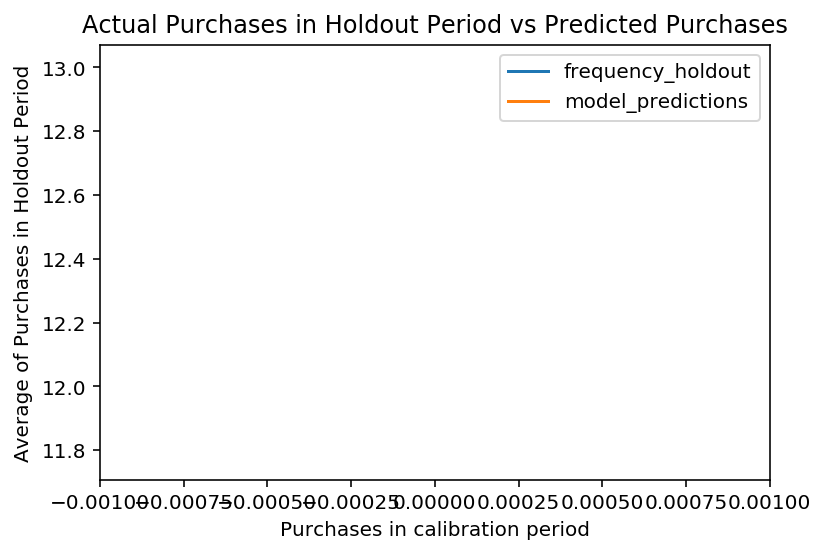

In [53]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Examine individual customers and their predicted number and amount of purchases

In [58]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[190]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.27737145494303878

## Customer segmentation
### http://blog.yhat.com/posts/customer-segmentation-using-python.html

### Define sessions

In [66]:
sessions = pd.DataFrame(OR.groupby('InvoiceNo')['StockCode'].apply(list))

In [69]:
sessions.head(2)

,StockCode
InvoiceNo,
536365,"[21730, 22752, 71053, 84029E, 84029G, 84406B, ..."
536366,"[22632, 22633]"


## MLxtend
### https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
### https://sebastianraschka.com/pdf/software/mlxtend-0.6.0.pdf

In [70]:
#https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/#frequent-itemsets-via-apriori-algorithm
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import OnehotTransactions
oht = OnehotTransactions()
oht_ary = oht.fit(list(sessions.StockCode)).transform(list(sessions.StockCode))

In [71]:
OHTdf = pd.DataFrame(oht_ary, columns=oht.columns_)
#OHTdf

In [72]:
frequent_itemsets = apriori(OHTdf, min_support=0.02, use_colnames=True)

In [73]:
AR = association_rules(frequent_itemsets, metric="lift", min_threshold=10)

In [74]:
AR.sort_values('lift',ascending=False)#.head(10)

,antecedants,consequents,support,confidence,lift
34,(22698),"(22699, 22697)",0.034767,0.706649,20.298685
31,"(22699, 22697)",(22698),0.034813,0.705729,20.298685
35,(22697),"(22699, 22698)",0.046009,0.533990,19.666706
30,"(22699, 22698)",(22697),0.027152,0.904841,19.666706
14,(22698),(22697),0.034767,0.825293,17.937731
15,(22697),(22698),0.046009,0.623645,17.937731
33,(22699),"(22698, 22697)",0.048321,0.508443,17.719994
32,"(22698, 22697)",(22699),0.028693,0.856240,17.719994
26,(23300),(23301),0.034359,0.720317,17.405153
27,(23301),(23300),0.041385,0.598028,17.405153


In [75]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [76]:
#Filter to show only those transactions with multiple products and a support of 0.8 minimally
frequent_itemsets[ (frequent_itemsets['length'] >= 2) &
                  (frequent_itemsets['support'] >= 0.02) ]

,support,itemsets,length
246,0.020353,"[20712, 21931]",2
247,0.024251,"[20712, 85099B]",2
248,0.022936,"[20719, 20724]",2
249,0.020670,"[20719, 22355]",2
250,0.022030,"[20723, 20724]",2
251,0.022982,"[20724, 22355]",2
252,0.023662,"[20724, 22356]",2
253,0.023843,"[20725, 20726]",2
254,0.029056,"[20725, 20727]",2
255,0.025158,"[20725, 20728]",2


## Model by customer rather than invoice

In [77]:
customer_sessions = pd.DataFrame(OR.groupby('CustomerID')['StockCode'].apply(list))
len(customer_sessions)
customer_sessions.head(4)

4339

,StockCode
CustomerID,
12346.0,[23166]
12347.0,"[20780, 20782, 21064, 21171, 21731, 22195, 222..."
12348.0,"[21211, 21213, 21213, 21725, 21977, 21977, 219..."
12349.0,"[20685, 20914, 21086, 21136, 21231, 21232, 214..."


In [78]:
#from mlxtend.frequent_patterns import apriori, association_rules
#from mlxtend.preprocessing import OnehotTransactions
#oht = OnehotTransactions()
customer_sessionsOHT = oht.fit(customer_sessions.StockCode).transform(customer_sessions.StockCode)

In [79]:
customer_sessionsOHTdf = pd.DataFrame(customer_sessionsOHT, columns=oht.columns_)

In [105]:
customer_sessions_frequent_itemsets = apriori(customer_sessionsOHTdf, min_support=0.04, use_colnames=True)

In [100]:
customer_sessions_frequent_itemsets['length'] = customer_sessions_frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [101]:
customer_sessions_frequent_itemsets[ (customer_sessions_frequent_itemsets['length'] >= 2) &
                  (customer_sessions_frequent_itemsets['support'] >= 0.02) ]

,support,itemsets,length
174,0.069140,"[20725, 20727]",2
175,0.070984,"[20725, 20728]",2
176,0.069601,"[20725, 22382]",2
177,0.065222,"[20725, 22383]",2
178,0.067988,"[20725, 22384]",2
179,0.061304,"[20725, 23209]",2
180,0.062687,"[20725, 85099B]",2
181,0.060152,"[20726, 22382]",2
182,0.060383,"[20727, 20728]",2
183,0.061304,"[20727, 22382]",2


In [103]:
AR = association_rules(customer_sessions_frequent_itemsets, metric="lift", min_threshold=10)

In [106]:
AR.sort_values('lift',ascending=False)#.head(10)

,antecedants,consequents,support,confidence,lift
3,"(22699, 22697)",(22698),0.073980,0.813084,11.059473
4,(22698),"(22699, 22697)",0.073519,0.818182,11.059473
2,"(22699, 22698)",(22697),0.062687,0.959559,10.758464
5,(22697),"(22699, 22698)",0.089191,0.674419,10.758464
0,(22698),(22697),0.073519,0.927900,10.403506
1,(22697),(22698),0.089191,0.764858,10.403506


In [131]:
whos DataFrame

Variable                              Type         Data/Info
------------------------------------------------------------
AR                                    DataFrame          antecedants     con<...>91    0.674419  10.758464
customer_sessions                     DataFrame                             <...>\n[4339 rows x 1 columns]
customer_sessions_frequent_itemsets   DataFrame          support            <...>n\n[748 rows x 2 columns]
returning_customers_summary           DataFrame                frequency  re<...>\n[2790 rows x 5 columns]
sessions                              DataFrame                             <...>n[22061 rows x 1 columns]


In [121]:
# del frequent_itemsets

In [130]:
whos ndarray

No variables match your requested type.


## Use pomegranate library for Bayesian network

In [ ]:
from pomegranate import *

In [ ]:
# # The guests initial door selection is completely random
# guest = DiscreteDistribution( { 'A': 1./3, 'B': 1./3, 'C': 1./3 } )

# # The door the prize is behind is also completely random
# prize = DiscreteDistribution( { 'A': 1./3, 'B': 1./3, 'C': 1./3 } )

# # Monty is dependent on both the guest and the prize. 
# monty = ConditionalProbabilityTable(
#         [[ 'A', 'A', 'A', 0.0 ],
#          [ 'A', 'A', 'B', 0.5 ],
#          [ 'A', 'A', 'C', 0.5 ],
#          [ 'A', 'B', 'A', 0.0 ],
#          [ 'A', 'B', 'B', 0.0 ],
#          [ 'A', 'B', 'C', 1.0 ],
#          [ 'A', 'C', 'A', 0.0 ],
#          [ 'A', 'C', 'B', 1.0 ],
#          [ 'A', 'C', 'C', 0.0 ],
#          [ 'B', 'A', 'A', 0.0 ],
#          [ 'B', 'A', 'B', 0.0 ],
#          [ 'B', 'A', 'C', 1.0 ],
#          [ 'B', 'B', 'A', 0.5 ],
#          [ 'B', 'B', 'B', 0.0 ],
#          [ 'B', 'B', 'C', 0.5 ],
#          [ 'B', 'C', 'A', 1.0 ],
#          [ 'B', 'C', 'B', 0.0 ],
#          [ 'B', 'C', 'C', 0.0 ],
#          [ 'C', 'A', 'A', 0.0 ],
#          [ 'C', 'A', 'B', 1.0 ],
#          [ 'C', 'A', 'C', 0.0 ],
#          [ 'C', 'B', 'A', 1.0 ],
#          [ 'C', 'B', 'B', 0.0 ],
#          [ 'C', 'B', 'C', 0.0 ],
#          [ 'C', 'C', 'A', 0.5 ],
#          [ 'C', 'C', 'B', 0.5 ],
#          [ 'C', 'C', 'C', 0.0 ]], [guest, prize] )  

# # State objects hold both the distribution, and a high level name.
# s1 = State( guest, name="guest" )
# s2 = State( prize, name="prize" )
# s3 = State( monty, name="monty" )

# # Create the Bayesian network object with a useful name
# model = BayesianNetwork( "Monty Hall Problem" )

# # Add the three states to the network 
# model.add_states(s1)

# # Add transitions which represent conditional dependencies, where the second node is conditionally dependent on the first node (Monty is dependent on both guest and prize)
# # model.add_transition(s1, s3)
# # model.add_transition(s2, s3)
# # model.bake()



# d = NormalDistribution( 0, 1 ) # The normal distribution
# plt.figure( figsize=(10,6) )
# d.plot( n=100000, edgecolor='c', facecolor='c', alpha=1, bins=50 )

# print (d.log_probability(3))
# print (d.log_probability(-3))

## Instacart

In [ ]:
# # Read in data and make appropriate joins
# aisles = pd.read_csv('aisles.csv',sep=',',error_bad_lines=False)

# products = pd.read_csv('products.csv',sep=',',error_bad_lines=False)

# orders = pd.read_csv('orders.csv',sep=',',error_bad_lines=False)

# departments = pd.read_csv('departments.csv',sep=',',error_bad_lines=False)

# order_products__prior = pd.read_csv('order_products__prior.csv',sep=',',error_bad_lines=False)

# order_products__train = pd.read_csv('order_products__train.csv',sep=',',error_bad_lines=False)

# product_aisle = pd.merge(products,aisles,on='aisle_id')

# product_aisle_department = pd.merge(product_aisle,departments,on='department_id')

# user_order = pd.merge(order_products__train,orders,on='order_id')

# user_order = user_order.sort_values(by='order_id',ascending='False')

#aisles.head(10)
#products.head(10)
#orders.head(10)
#departments.head(10)
#order_products__prior.head(10)
#order_products__train.head(10)
#product_aisle.head(10)
#product_aisle_department.head(10)
#user_order.head(10)

# Master = pd.merge(user_order,product_aisle_department,on='product_id')
# Master = Master.sort_values(by=['order_id','product_id'],ascending='False')
# Master.head(10)

#Master.to_csv('Master.csv')

# #https://stackoverflow.com/questions/15222754/group-by-pandas-dataframe-and-select-most-common-string-factor

# weekdays = pd.DataFrame(Master.groupby(['order_dow','department'])['product_name'].agg(lambda x:x.value_counts().index[0]))

# weekdays = weekdays.unstack(0)

# weekdays.head()

# weekdays.to_csv('Weekdays.csv')

In [ ]:
# Master = pd.read_csv('Master.csv')
# #Master.head()
# Master.drop(['Unnamed: 0'], axis = 1, inplace = True)

# Master.head(1)

In [ ]:
#weekdays = pd.read_csv('weekdays.csv')

# trim = Master.iloc[:,[0,1,10]]
# trim.head()

# sessions = pd.DataFrame(trim.groupby('order_id')['product_id'].apply(list))
# sessions.head()

#sessions.product_id[:10]

# #sessions.to_csv('Sessions.csv')

In [ ]:
# sessions = pd.read_csv('sessions.csv')
# sessions.head()